# Morphology prediction using GO terms only

Ported from [Jaren Bresnick's work in summer 2023](https://github.com/Jaren-Bresnick/BDS-SROP-2023).

In [1]:
import pandas as pd

gene_labels = pd.read_csv('../data/cpg0016/version_2023-06-14/gene_labels.csv')

In [2]:
gene_labels

,Metadata_Symbol,Metadata_NCBI_Gene_ID,Indeterminate,Negative,Positive,gene_label
0,A2M,2,1,1,3,Positive
1,A3GALT2,127550,1,0,4,Positive
2,A4GALT,53947,0,0,5,Positive
3,A4GNT,51146,3,0,3,Indeterminate
4,AACS,65985,1,0,4,Positive
...,...,...,...,...,...,...
7970,ZSCAN32,54925,4,0,1,Indeterminate
7971,ZSCAN4,201516,0,0,3,Positive
7972,ZSCAN5A,79149,0,0,5,Positive
7973,ZSCAN9,7746,0,0,5,Positive


In [3]:
uniprot_idmapping = pd.read_excel('../data/GO/HUMAN_9606_idmapping.xlsx', dtype='str')

In [4]:
ncbi_col = 'GeneID (EntrezGene)'
go_col = 'Unnamed: 6'

In [5]:
# Get definitivey labeled subset of morphology data
definite_gene_labels = gene_labels[gene_labels.gene_label.isin(['Positive', 'Negative'])]

In [6]:
# Expand lists from ID mapping table
gene_id_lists = uniprot_idmapping[ncbi_col].str.split('; ')
go_lists = uniprot_idmapping[go_col].str.split('; ')

In [7]:
go_long_df = (
    pd.DataFrame({'Gene_ID': gene_id_lists, 'GO': go_lists})
    .explode('Gene_ID')
    .explode('GO')
    .dropna()
)

# Filter down GO lists

go_long_df = go_long_df[
    go_long_df.Gene_ID.astype('int64').isin(definite_gene_labels['Metadata_NCBI_Gene_ID'])
].drop_duplicates()

In [8]:
# Make matrix

go_df = go_long_df.pivot_table(
    index='Gene_ID',
    columns='GO',
    aggfunc=lambda _: 1,
    fill_value=0
)

Construct vectors for ML

In [9]:
y = (
    pd.DataFrame(
        {
            'Gene_ID': definite_gene_labels['Metadata_NCBI_Gene_ID'],
            'Label': definite_gene_labels['gene_label']
        }
    )
    .set_index('Gene_ID')
    .Label
    .map({'Positive': 0, 'Negative': 1})
)
y

Gene_ID
2         0
127550    0
53947     0
65985     0
13        0
         ..
64288     0
201516    0
79149     0
7746      0
151112    0
Name: Label, Length: 6996, dtype: int64

In [10]:
go_df.index = go_df.index.astype('int64')

In [11]:
x = go_df.sort_index()

In [12]:
y.shape, x.shape

((6996,), (6968, 15739))

ML Run

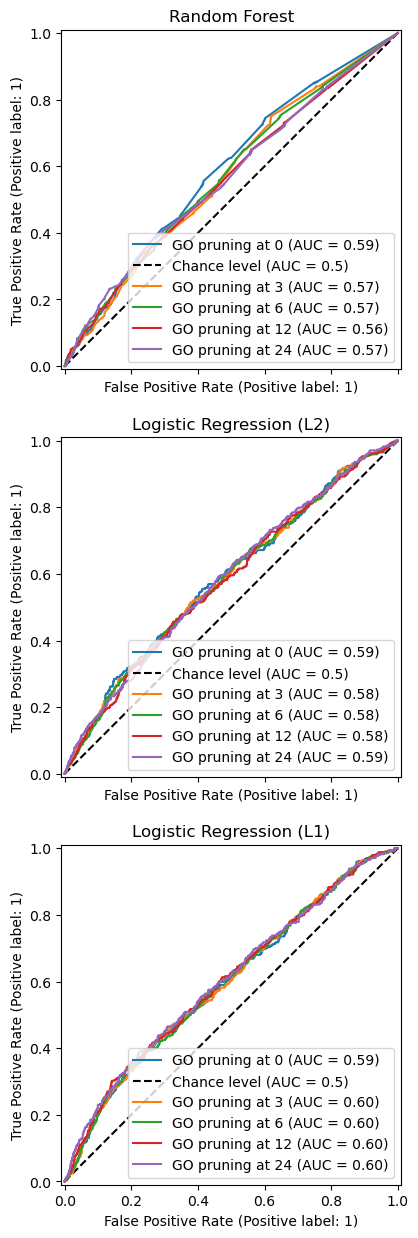

In [13]:
# Defining inputs for machine learning models
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.metrics import roc_curve, auc, accuracy_score, RocCurveDisplay
from sklearn.preprocessing import label_binarize, LabelEncoder
from matplotlib.pyplot import subplots

models = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression (L2)': LogisticRegression(penalty='l2'),
    'Logistic Regression (L1)': LogisticRegression(penalty='l1', solver='liblinear')
}

cv = StratifiedKFold(n_splits=10, random_state=20240131, shuffle=True)

fig, ax = subplots(nrows=len(models), ncols=1, sharex=True, sharey=True, squeeze=False, figsize=(5,15))

col = 0
first = True
for pruning in [0,3,6,12,24]:

    x_pruned = x.loc[:, x.sum(axis='index') >= pruning]
    y_pruned = y.filter(x_pruned.index, axis='index').sort_index()

    for row, (name, model) in enumerate(models.items()):
        probs = cross_val_predict(model, x_pruned, y_pruned, cv=cv, method='predict_proba')[:, 1]
        RocCurveDisplay.from_predictions(y_pruned, probs, name=f'GO pruning at {pruning}', plot_chance_level=first, ax=ax[row, col])
        if first:
            ax[row, col].set_title(f'{name}')

    first = False

Pruning distribution

In [16]:
for pruning in [0,3,6,12,24]:
    print(f'{(x.sum(axis="index") >= pruning).sum()} terms occur {pruning} or more times.')

15739 terms occur 0 or more times.
7550 terms occur 3 or more times.
4045 terms occur 6 or more times.
2008 terms occur 12 or more times.
944 terms occur 24 or more times.


In [19]:
(x.columns.str.strip() == x.columns).all()

True